In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import sys
sys.path.append('..')
sys.path.append('../..')

from toy_tasks.NN import encode, GeneralNet# GeneralNetSIREN, GeneralNetPosEnc
from torch.func import vmap, grad, jacrev, jacfwd, functional_call
import torch.nn.functional as F

In [2]:
from torch.nn.functional import relu, celu, softplus, tanh

class GeneralNetPosEnc(GeneralNet):
    """ NOTE: need to compute proper ks yourself. For example
    enc_dim = 2*nx*config['N_posenc']
    model = GeneralNetPosEnc(ks=[2, enc_dim, 20, 20, 1])
    """
    def __init__(self, ks, act=tanh, N_posenc=None):
        super(GeneralNetPosEnc, self).__init__(ks=ks, act=act)
        # self.N_posenc = ks[1]//(2*self.ks[0])
        self.N_posenc = N_posenc
    def forward(self, x, z):
        x = encode(x, N=self.N_posenc) ## positional encoding
        x = torch.hstack([x, z]) ## stack with latent code
        x = self.fcs[0](x) # 0 -> 1
        for i in range(2, self.D+1):
            x = self.fcs[i-1](self.act(x))
        return torch.sigmoid(x)

from torch import nn
class Net(nn.Module):
    def __init__(self, ks):
        super(Net, self).__init__()
        ## Feature-sizes
        self.ks = ks
        ## Fully-connected layers
        self.fcs = nn.ModuleList([nn.Linear(in_features, out_features)
            for in_features, out_features in zip(self.ks[:-1],self.ks[1:])])
        ## Depth
        self.D = len(self.fcs)
    def forward(self, x, z):
        x_ = self.fcs[0](torch.hstack([x, z]))
        for i in range(2,self.D+1):
            x_ = self.fcs[i-1](relu(x_))
        return x_

from siren import SIREN
class PosEncSIREN(SIREN):
    """Wrapper around SIREN"""
    def __init__(self, ks, w0=1.0, w0_initial=30.0, initializer='siren', c=6, N_posenc=0):
        in_features = ks[0]
        layers = ks[1:-1]
        out_features = ks[-1]
        # if N_posenc>0: w0_initial = 1.0 ## with manual posenc, there is no need to treat SIRENs first layer differently  
        SIREN.__init__(self, layers, in_features, out_features, w0, w0_initial, initializer=initializer, c=c)
        self.ks = ks
        self.N_posenc = N_posenc
    def forward(self, x, z):
        if self.N_posenc:
            x = encode(x, N=self.N_posenc) ## positional encoding
        x = torch.hstack([x, z]) ## stack with latent code
        return torch.sigmoid(self.network(x))


class GeneralNetFFN(GeneralNet):
    """ Wrapper around FFN (Fourier Feature Network)[Tancik] """
    def __init__(self, ks, act=tanh, N_ffeat=0, sigma=1, nx=2):
        super(GeneralNetFFN, self).__init__(ks=ks, act=act)
        self.N_ffeat = N_ffeat
        if self.N_ffeat:
            self.B = torch.normal(0, sigma**2, size=[self.N_ffeat, nx])
    def forward(self, x, z):
        if self.N_ffeat:
            x_B = 2*torch.pi*x@self.B.T
            x_sin = torch.sin(x_B)
            x_cos = torch.cos(x_B)
            x = torch.hstack([x_sin, x_cos])
        x = torch.hstack([x, z]) ## stack with latent code
        x = self.fcs[0](x) # 0 -> 1
        for i in range(1, self.D): # 1 --> D
            x = self.fcs[i](self.act(x))
        return torch.sigmoid(x)

class DualNet(nn.Module):
    """A wrapper to treat two NN models as one."""
    def __init__(self, models):
        super(DualNet, self).__init__()
        self.models = nn.ModuleList(models)
    def forward(self, x, z):
        """Both models have same inputs and a single output each. Forward the inputs to each and stack the outputs. """
        return torch.stack([model(x, z) for model in self.models], dim=-1)

In [3]:
nx = 2
ny = 2

def init(arch="SIREN+POSENC", use_two_models=True, nz=0):
    assert arch in ["SIREN", "SIREN+POSENC", "FFN"], "unknown architecture"
    assert use_two_models in [False, True]
    if arch=="SIREN":
        if use_two_models:
            model = DualNet([PosEncSIREN(ks=[nx+nz, 256, 128, 1]) for _ in range(2)])
        else:
            model = PosEncSIREN(ks=[nx+nz, 256, 256, 2], w0_initial=30)
    elif arch=="SIREN+POSENC":
        ## Critical: w0_initial. Higher N_posenc needs lower w0_initial
        N_posenc = 1 ## 1 is for periodic BC
        enc_dim = 2*nx*N_posenc
        if use_two_models:
            model = DualNet([PosEncSIREN(ks=[enc_dim+nz, 256, 128, 1], N_posenc=N_posenc, w0_initial=3.0) for _ in range(2)])
        else:
            model = PosEncSIREN(ks=[enc_dim+nz, 256, 256, 2], N_posenc=N_posenc, w0_initial=3.0)
    elif arch=="FFN":
        ## Critical: N_posenc and sigma.
        N_ffeat = 128
        enc_dim = 2*N_ffeat if N_ffeat else nx
        if use_two_models:
            model = DualNet([GeneralNetFFN(ks=[enc_dim+nz, 256, 128, 1], N_ffeat=N_ffeat, sigma=3) for _ in range(2)])
        else:
            model = GeneralNetFFN(ks=[enc_dim+nz, 256, 256, 2], N_ffeat=N_ffeat, sigma=3)
    elif arch=="FFN+POSENC":
        raise NotImplementedError

    params = dict(model.named_parameters())

    return model, params

model, params = init()

In [5]:
## Define differential operators via automatic differentation
def f(params, x, z):
    """
    Stateless call to the model.
    That this works for
    * single inputs:
    x: [nx]
    z: [nz]
    returns: [ny]
    -- and -- 
    * batch inputs:
    x: [B, nx]
    z: [B, nz]
    returns: [B, ny]
    """
    return functional_call(model, params, (x, z))


### JACOBIAN ###
## Jacobian wrt x : df/dx
f_x = jacrev(f, argnums=1) ## not for batch!
vf_x = vmap(f_x, in_dims=(None, 0, 0), out_dims=(0)) ## output [B, ny, nx]

## Jacobian wrt z : df/dz
f_z = jacrev(f, argnums=2) ## not for batch!
vf_z = vmap(f_z, in_dims=(None, 0, 0), out_dims=(0))  ## output [B, ny, nz]


### HESSIAN ###
f_xx = jacfwd(f_x, argnums=1) ## not for batch!
vf_xx = vmap(f_xx, in_dims=(None, 0, 0), out_dims=(0)) ## output [B, ny, nx, nx]


### LAPLACIAN ###
laplacian = lambda params, x, z : f_xx(params, x, z).diagonal(dim1=-1, dim2=-2).sum(-1)
v_laplacian = vmap(laplacian, in_dims=(None, 0, 0), out_dims=(0)) ## output [B, ny]



## Test for debugging and example usage##
if False:
    nz = 1
    model, params = init(nz=nz)
    B = 5
    xs = torch.rand([B, nx])
    zs = torch.rand([B, nz])


    ## Function ##
    ys = f(params, xs, zs)
    print("batch", xs.shape, zs.shape, ys.shape)
    x, z = xs[0], zs[0]
    y = f(params, x, z)
    print("no batch", x.shape, z.shape, y.shape)

    # NOTE: this should not be evaluated for batch.
    # Otherwise, it will compute gradients of df(x_i) / dx_j which are all 0 for i/=j, e.g.
    # print(f_x(params, xs, zs).shape) ## [B, ny, B, nx]
    # print(f_z(params, xs, zs).shape) ## [B, ny, B, nz]
    # We could take the diagonal, but that's just wasteful. Hence we vectorize properly.

    print("vf_x", vf_x(params, xs, zs).shape) ## [B, ny, nx]
    print("vf_z", vf_z(params, xs, zs).shape) ## [B, ny, nz]
    ##

    ## Laplacian ## 
    print("vf_xx", vf_xx(params, xs, zs).shape) ## [B, ny, nx, nx]
    ## NOTE: in some cases we might not want the full Hessian, but rather just its diagonal. Like for the Laplacian
    ## It's non-trivial to do, but maybe hvp can help. See https://github.com/google/jax/issues/3801
    ## Presumably we dont need fzzv, but it's completely analogous.
    ## Mixed derivatives like fxzv are also accesible.

    print("v_laplacian", v_laplacian(params, xs, zs).shape) ## [B, ny]

In [128]:
## Define differential operators via finite differences

def laplacian_conv(input_tensor, dx0, dx1):
    """
    Discrete Laplacian on a grid using convolution and circular padding.
    input_tensor: [bz, N0, N1]"""

    # Define a 3x3 Laplacian filter for 2D grids
    laplacian_filter = torch.tensor([[0,  1, 0],
                                     [1, -4, 1],
                                     [0,  1, 0]], dtype=torch.float32)

    ## Add a channel dimension for compatibility with conv2d
    laplacian_filter = laplacian_filter.view(1, 1, 3, 3)

    ## Apply circular padding to the input tensor and add a channel dimension
    input_tensor_padded = F.pad(input_tensor, (1, 1, 1, 1), mode='circular').unsqueeze(1)

    ## Apply 2D convolution with the Laplacian filter
    laplacian_result = F.conv2d(input_tensor_padded, laplacian_filter)

    ## Correctly scaled FD Laplacian is the ratio to the discretization size
    laplacian_result /= dx0*dx1

    ## Remove the channel dimension
    return laplacian_result.squeeze(1)


def gradient_conv(input_tensor, dx0, dx1):
    """Discrete gradient on a grid using convolution and circular padding.
    input_tensor: [bz, N0, N1]"""

    ## Define Sobel filters for computing partial derivatives
    sobel_x_filter = torch.tensor([[-1, 0, 1],
                                   [-2, 0, 2],
                                   [-1, 0, 1]], dtype=torch.float32)
    sobel_y_filter = sobel_x_filter.T

    ## Add a batch and channel dimension for compatibility with conv2d
    sobel_x_filter = sobel_x_filter.view(1, 1, 3, 3)
    sobel_y_filter = sobel_y_filter.view(1, 1, 3, 3)

    ## Apply circular padding to the input tensor and add a channel dimension
    input_tensor_padded = F.pad(input_tensor, (1, 1, 1, 1), mode='circular').unsqueeze(1)

    ## Apply 2D convolution with Sobel filters for x and y directions
    gradient_x = F.conv2d(input_tensor_padded, sobel_x_filter)
    gradient_y = F.conv2d(input_tensor_padded, sobel_y_filter)

    # Correctly scaled FD gradient is the ratio to the discretization size
    # 2h for central difference and 4 for normalizing the smoothing along the other dimension
    gradient_x /= 2*dx0*4
    gradient_y /= 2*dx1*4

    ## Remove the channel dimension
    return gradient_x.squeeze(1), gradient_y.squeeze(1)

In [7]:
def get_domain_grid(bounds, N0, N1):
    ## Meshgrid the domain
    x0s, dx0 = np.linspace(bounds[0], bounds[1], N0, endpoint=False, retstep=True)
    x1s, dx1 = np.linspace(bounds[2], bounds[3], N1, endpoint=False, retstep=True)
    X0, X1 = np.meshgrid(x0s, x1s)
    xs = np.vstack([X0.ravel(), X1.ravel()]).T
    xs = torch.tensor(xs).float()

    ## Discretization size manually
    # step = (bounds[1]-bounds[0])/N ## when using endpoint=False
    # Dx0 = bounds[1] - bounds[0]
    # Dx1 = bounds[3] - bounds[2]
    # dx0 = Dx0/N0
    # dx1 = Dx1/N1

    return xs, X0, X1, dx0, dx1

def tensor_product_xz(x, z):
    """
    Generate correct inputs for bx different xs and bz different zs.
    For each z we want to evaluate it at all xs and vice versa, so we need a tensor product between the rows of the two vectors.
    x: [bx, nx]
    z: [bz, nz]
    returns: [bx*bz, nx+nz]
    """
    z_tp = z.repeat_interleave(len(x), 0)
    x_tp = x.repeat(len(z), 1)
    # xz = torch.hstack([x_rep, z_rep])
    return x_tp, z_tp

In [143]:
def pairwise_dist_fields(y):
    """
    y: [num_fields, num_points, 2] tensor
    pairwise_dist[i, j] contains the distance between fields i and j
    """
    pairwise_dist = (y.unsqueeze(0) - y.unsqueeze(1)).norm(dim=-1).mean(-1)
    return pairwise_dist

def loss_diversity(y):
    """
    Returns the diversity loss.
    Compute all the pairwise distances.
    For every field, take the distance to the closest neighbour.
    Exponentiate all the distances for concavity/uniformity.
    Take mean of those.
    Square to be same order as constraints.
    y: [num_fields, num_points, 2] tensor
    """
    ## Compute pairwise distances
    distances = pairwise_dist_fields(y)
    ## Create a mask to exclude diagonal elements
    distances = distances.masked_fill(torch.eye(distances.size(0), dtype=torch.bool), float('inf'))
    ## Find the minimum distance for each point
    closest_dists, closest_inds = distances.min(dim=1)

    ## NOTE: we need .sqrt() or in general raising to some p<1, to prevent one distance from taking over the loss.
    ## This is analogous to a uniform distribution maximizing entropy.
    return -(closest_dists.sqrt()).mean().square()

F=0.0280, K=0.0570, deviation from bifurcation line=9.00e-04


1.05e-05, -1.00e+00, 0.00e+00: 100%|██████████| 1000/1000 [01:03<00:00, 15.74it/s]


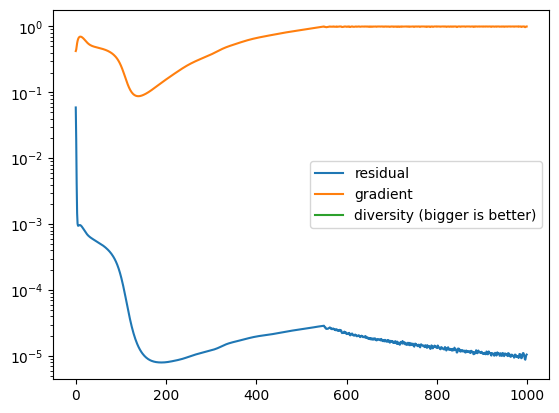

In [160]:
nz = 1
model, params = init(arch="SIREN+POSENC", use_two_models=True, nz=nz)

bounds = (0, 1, 0, 1) ## [0,1]^2 domain
N = 64
N0, N1 = N, N ## number of points in two spatial dimensions


## Diffusion
D1_, D2_ = .1, .05 # these are taken from gray_scott.ipynb grid solver
D1 = D1_ / (64*64) # scale to account for correct Laplacian
D2 = D2_ / (64*64) # scale to account for correct Laplacian

## Feed/kill rates
Fr, Kr = 0.028, 0.057 ## WORMS
# Fr, Kr = 0.102, 0.055 ## type rho: long patterns?
bifurcation_K = lambda Fr : -Fr + .5*Fr**.5 ## compute the exact pair
bifurcation_residual = lambda Fr, Kr : 4*(Fr+Kr)**2 - Fr
# Kr = bifurcation_K(Fr) ## get the exact kill rate to stay on the bifurcation line
print(f"F={Fr:.4f}, K={Kr:.4f}, deviation from bifurcation line={bifurcation_residual(Fr, Kr):.2e}")


torch.manual_seed(0)
bz = 10 ## Batch size
z = torch.randn(bz, nz) ## [bz, nz]
method = 'FD' # FD, AD
move_grid = True

## Precompute the grid
if method=="FD":
    x, _, _, dx0, dx1 = get_domain_grid(bounds, N0, N1)
    x_tp, z_tp = tensor_product_xz(x, z) ## [bz*bx, nx], [bz*bx, nz]


## Softclip instead of clip avoids oscillations in the loss, but hard clip still converges to smaller residuals
use_softclip = False
w_grad = 1e-4
if use_softclip:
    softplus = nn.Softplus(beta=10) # higher beta approaches hard clip in the limit
    softclip = lambda x, max_ : -softplus(-x + max_) + max_
    w_grad = 1e-2 # need to weight gradients more with softclip, otherwise it starts to converge toward trivial solution

## Log losses
loss_over_iters = {}
loss_over_iters['obj'] = {}
loss_over_iters['grad'] = {}
loss_over_iters['div'] = {}

## Optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-2)

## Train
for i in (pbar := trange(1000)):
    # if i==1000: opt = torch.optim.Adam(model.parameters(), lr=1e-3)  ## sometimes we can reinit optimizer for much better convergence. Probably escapes some bad optimum
    opt.zero_grad()
    
    if method=="AD":
        x = torch.rand(5000, nx) ## [bx, nx] from [0,1]^2 domain
        x_tp, z_tp = tensor_product_xz(x, z) ## [bz*bx, nx], [bz*bx, nz]
    elif method=="FD":
        if move_grid: ## Move the grid every iteration
            x_ = x + torch.rand(1,1)*(1/N)
            x_tp, z_tp = tensor_product_xz(x_, z) ## [bz*bx, nx], [bz*bx, nz]

    ys = model(x_tp, z_tp).reshape(len(z), len(x), ny)
    y0, y1 = ys[...,0], ys[...,1]
    ## First bz entries now correspond to all xs of the first latent code and so on

    ### AUTOMATIC DIFFERENTIATION
    if method=='AD':
        ## LAPLACIANS
        ## At bz codes \times bx points we have ny Laplacians
        ys_lap = v_laplacian(params, x_tp, z_tp).reshape(len(z), len(x), ny) ## [bz, bx, ny]
        y0_lap, y1_lap = ys_lap[...,0], ys_lap[...,1]

        ## GRADIENTS
        y_x = vf_x(params, x_tp, z_tp).reshape(len(z), len(x), ny, nx) ## [bz, bx, ny, nx]
        grad_norms = y_x[0].square().mean()
    
    ### FINITE DIFFERENCES
    elif method=='FD':
        ## Reshape to grid so we can apply convolution
        Y0, Y1 = y0.reshape(len(z), N0, N1), y1.reshape(len(z), N0, N1)

        ## LAPLACIANS
        Y0_lap = laplacian_conv(Y0, dx0, dx1)
        Y1_lap = laplacian_conv(Y1, dx0, dx1)
        
        ## Reshape back to vector
        y0_lap = Y0_lap.reshape(len(z),-1)
        y1_lap = Y1_lap.reshape(len(z),-1)

        ## GRADIENTS
        Y0_x0, Y0_x1 = gradient_conv(Y0, dx0, dx1)
        Y1_x0, Y1_x1 = gradient_conv(Y1, dx0, dx1)

        y0_grad_norm = (Y0_x0.square() + Y0_x1.square()).mean()
        y1_grad_norm = (Y1_x0.square() + Y1_x1.square()).mean()
        grad_norms = (y0_grad_norm+y1_grad_norm)
        grad_norms /= 64 ## hyperparam. Properly normalizing grads after convolution makes them 8 times larger. So, here, 8^2=64 smaller.
    

    ## OBJECTIVE ##
    y011 = y0*y1*y1 ## reaction rate u*v*v
    res1_field = -y011 + Fr*(1-y0)  + D1*y0_lap
    res2_field =  y011 - (Fr+Kr)*y1 + D2*y1_lap
    loss_obj = (res1_field.square() + res2_field.square()).mean()

    ## MAGNITUDE ##
    ## Don't allow constant solutions, since we want the bifurcations
    if use_softclip:
        loss_grad = -softclip(grad_norms, 1) ## gradient norm
    else:
        loss_grad = -torch.clip(grad_norms, max=1) ## gradient norm

    ## DIVERSITY ##
    # loss_div0 = loss_diversity(y0)
    # loss_div1 = loss_diversity(y1)
    # loss_div = loss_div0 + loss_div1
    loss_div = torch.tensor([0.0])
    
    ## OPTIMIZE ##
    loss = loss_obj + w_grad*loss_grad + 1e-7*loss_div
    loss.backward()
    opt.step()

    ## LOG ##
    pbar.set_description(f"{loss_obj.item():.2e}, {loss_grad.item():.2e}, {loss_div.item():.2e}")
    loss_over_iters['obj'][i] =  loss_obj.item()
    loss_over_iters['grad'][i] = -loss_grad.item()
    loss_over_iters['div'][i] = -loss_div.item()


plt.plot(list(loss_over_iters['obj'].keys()), list(loss_over_iters['obj'].values()), label='residual')
plt.plot(list(loss_over_iters['grad'].keys()), list(loss_over_iters['grad'].values()), label='gradient')
plt.plot(list(loss_over_iters['div'].keys()), list(loss_over_iters['div'].values()), label='diversity (bigger is better)')
plt.semilogy()
plt.legend()
plt.show()

### Plotting for batch

In [161]:
## Plot using FD
x, X0, X1, dx0, dx1 = get_domain_grid(bounds, N0, N1)
# torch.manual_seed(0)
# z = torch.randn(bz, nz) ## [bz, nz]
x_tp, z_tp = tensor_product_xz(x, z) ## [bz*bx, nx], [bz*bx, nz]

with torch.no_grad():
    ys = model(x_tp, z_tp).reshape(len(z), len(x), ny).squeeze(0)
    Y0, Y1 = ys[...,0].reshape(bz,*X0.shape), ys[...,1].reshape(bz,*X0.shape)
    ## Reshape to grid so we can apply convolution
    Y0, Y1 = y0.reshape(len(z), N0, N1), y1.reshape(len(z), N0, N1)

    ## LAPLACIANS
    Y0_lap = laplacian_conv(Y0, dx0, dx1)
    Y1_lap = laplacian_conv(Y1, dx0, dx1)

    ## Reshape back to vector
    y0_lap = Y0_lap.reshape(len(z),-1)
    y1_lap = Y1_lap.reshape(len(z),-1)

    ## GRADIENTS
    Y0_x0, Y0_x1 = gradient_conv(Y0, dx0, dx1)
    Y1_x0, Y1_x1 = gradient_conv(Y1, dx0, dx1)


figscale = 2
def format_ax(ax, im):
    ax.axis('scaled')
    ax.axis('off')
    # plt.colorbar(im, ax=ax)

for iy, (Y_, Y_x0_, Y_x1_, Y_lap_) in enumerate(zip([Y0, Y1], [Y0_x0, Y1_x0], [Y0_x1, Y1_x1], [Y0_lap, Y1_lap])):

    fig, axs = plt.subplots(4, len(z), figsize=(figscale*len(z),figscale*4))
    for iz, (Y, Y_x0, Y_x1, Y_lap) in enumerate(zip(Y_, Y_x0_, Y_x1_, Y_lap_)):

        ax = axs[0, iz]
        im = ax.imshow(Y.detach(), origin='lower')
        format_ax(ax, im)

        ax = axs[1, iz]
        im = ax.imshow(Y_x0.detach(), origin='lower', extent=bounds)
        format_ax(ax, im)

        ax = axs[2, iz]
        im = ax.imshow(Y_x1.detach(), origin='lower', extent=bounds)
        format_ax(ax, im)

        ax = axs[3, iz]
        im = ax.imshow(Y_lap, origin='lower')
        format_ax(ax, im)

    # fig.suptitle(f'Component {iy}')
plt.show()

### Plotting for single (TODO: has not been updated to batch)

In [ ]:
## Plot using AD
x, X0, X1, dx0, dx1 = get_domain_grid(bounds, N0, N1)
z = torch.randn(1, nz) ## latent code does not matter for single

x_tp, z_tp = tensor_product_xz(x, z)
y = model(x_tp, z_tp).detach().reshape(len(z), len(x), ny)
ys_lap = v_laplacian(params, x_tp, z_tp).reshape(len(z), len(x), ny) ## [bz, bx, ny]
y_x = vf_x(params, x_tp, z_tp).reshape(len(z), len(x), ny, nx) ## [bz, bx, ny, nx]


fig, axs = plt.subplots(2, 4, figsize=(24,6))
for iy in [0,1]:
    ax = axs[iy,0]
    Y = y[0,:,iy].detach().numpy().reshape(X0.shape)
    im = ax.imshow(Y, origin='lower', extent=bounds)
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(f'y{iy} {Y.min():.4f}, {Y.max():.4f}')
    plt.colorbar(im, ax=ax)


    ax = axs[iy,1]
    Y_x = y_x[0,:,iy,0].detach().numpy().reshape(X0.shape)
    im = ax.imshow(Y_x, origin='lower', extent=bounds)
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(f'y{iy}_x0 {Y_x.min():.4f}, {Y_x.max():.4f}')
    plt.colorbar(im, ax=ax)


    ax = axs[iy,2]
    Y_x = y_x[0,:,iy,1].detach().numpy().reshape(X0.shape)
    im = ax.imshow(Y_x, origin='lower', extent=bounds)
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(f'y{iy}_x1 {Y_x.min():.4f}, {Y_x.max():.4f}')
    plt.colorbar(im, ax=ax)


    ax = axs[iy,3]
    Y_lap = ys_lap[0,:,iy].detach().numpy().reshape(X0.shape)
    im = ax.imshow(Y_lap, origin='lower', extent=bounds)
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(f'y{iy}_lap {Y_lap.min():.4f}, {Y_lap.max():.4f}')
    plt.colorbar(im, ax=ax)

plt.show()

In [ ]:
## Plot using FD
x, X0, X1, dx0, dx1 = get_domain_grid(bounds, N0, N1)
z = torch.randn(1, nz) ## [bz, nz]
x_tp, z_tp = tensor_product_xz(x, z) ## [bz*bx, nx], [bz*bx, nz]

ys = model(x_tp, z_tp).reshape(len(z), len(x), ny).squeeze(0)
Y0, Y1 = ys[...,0].reshape(X0.shape), ys[...,1].reshape(X0.shape)

fig, axs = plt.subplots(2, 4, figsize=(24,6))

for iy, Y in enumerate([Y0, Y1]):
    ax = axs[iy,0]
    im = ax.imshow(Y.detach(), origin='lower')
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(f'y{iy} {Y.min():.4f}, {Y.max():.4f}')
    plt.colorbar(im, ax=ax)


    Y_x0, Y_x1 = gradient_conv(Y, dx0, dx1)
    ax = axs[iy,1]
    im = ax.imshow(Y_x0.detach(), origin='lower', extent=bounds)
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(f'y{iy}_x0 {Y_x0.min():.4f}, {Y_x0.max():.4f}')
    plt.colorbar(im, ax=ax)


    ax = axs[iy,2]
    im = ax.imshow(Y_x1.detach(), origin='lower', extent=bounds)
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(f'y{iy}_x1 {Y_x1.min():.4f}, {Y_x1.max():.4f}')
    plt.colorbar(im, ax=ax)


    ax = axs[iy,3]
    Y_lap = laplacian_conv(Y, dx0, dx1).detach()
    im = ax.imshow(Y_lap, origin='lower')
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(f'y{iy}_lap {Y_lap.min():.4f}, {Y_lap.max():.4f}')
    plt.colorbar(im, ax=ax)

# fig.suptitle('Title')
plt.show()

In [ ]:
## Convergence.
## This is a sanity check. If the NN is too expressive, the higher resolution samples will be very noisy and the field will be invalid.
fig, axs = plt.subplots(2,4, figsize=(18,6))

for i, N in enumerate([64, 128, 256, 512]):
    x, X0, X1, _, _ = get_domain_grid(bounds, N, N)
    x_tp, z_tp = tensor_product_xz(x, z) ## [bz*bx, nx], [bz*bx, nz]

    ys = model(x_tp, z_tp).reshape(len(z), len(x), ny).squeeze(0)
    Y0, Y1 = ys[...,0].reshape(X0.shape), ys[...,1].reshape(X0.shape)
    # Y0_lap = laplacian_conv(Y0)
    # Y1_lap = laplacian_conv(Y1)
    
    ax = axs[0,i]
    im = ax.imshow(Y0.detach(), origin='lower')
    ax.axis('scaled')
    ax.axis('off')
    
    # Y_lap = laplacian_conv(Y).detach()
    ax = axs[1,i]
    im = ax.imshow(Y1.detach(), origin='lower')
    ax.axis('scaled')
    ax.axis('off')
    
plt.show()